<a href="https://colab.research.google.com/github/shubhamraut789/AOS_A1_git/blob/main/SMAIemotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ 1. Mount Google Drive and Unzip Dataset
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Correct zip path (must point to actual .zip file in MyDrive)
zip_path = '/content/drive/MyDrive/emotion_dataset.zip'  # <- Update this if your zip has a different name
extract_path = '/content/emotion_dataset'  # Extract to local Colab

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to:", extract_path)

# Set DATA_ROOT to extracted folder
DATA_ROOT = "/content/emotion_dataset/emotion_dataset"

# Validate dataset structure
if not os.path.exists(os.path.join(DATA_ROOT, "Train")) or not os.path.exists(os.path.join(DATA_ROOT, "Test")):
    raise RuntimeError("❌ 'emotion_dataset/Train' and 'emotion_dataset/Test' not found.")

import torch

if torch.cuda.is_available():
    print("✅ GPU is enabled:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU not available.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted to: /content/emotion_dataset
✅ GPU is enabled: Tesla T4


In [10]:
# ✅ 2. Import Libraries
import glob
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from PIL import Image
from IPython.display import display, HTML, Audio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Install and Login to Weights & Biases
!pip install -q wandb
import wandb
wandb.login()

class VGGFaceModel(nn.Module):
    def __init__(self, num_classes=3):
        super(VGGFaceModel, self).__init__()
        base_model = models.vgg16(pretrained=True)
        self.features = base_model.features
        self.avgpool = base_model.avgpool  # ✅ This handles downsampling to (7x7)
        in_features = base_model.classifier[0].in_features  # should be 25088
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)  # ✅ Crucial downsampling
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x





wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [11]:
# ✅ 3. Configuration
WANDB_PROJECT = "EmotionRecognition"
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['happy', 'sad', 'angry']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

In [12]:
# ✅ 4. Load Dataset

def get_image_paths_and_labels(folder):
    image_paths, labels = [], []
    print(f"\n Scanning folder: {folder}")
    for emotion in class_names:
        emotion_folder = os.path.join(folder, emotion)
        if not os.path.exists(emotion_folder):
            print(f" Missing: {emotion_folder}")
            continue
        emotion_files = glob.glob(os.path.join(emotion_folder, "*"))
        print(f" {emotion}: {len(emotion_files)} images")
        for img_path in emotion_files:
            image_paths.append(img_path)
            labels.append(class_to_idx[emotion])
    print(f" Loaded {len(image_paths)} images from {folder}")
    return image_paths, labels

train_paths, train_labels = get_image_paths_and_labels(os.path.join(DATA_ROOT, "Train"))
test_paths, test_labels = get_image_paths_and_labels(os.path.join(DATA_ROOT, "Test"))


 Scanning folder: /content/emotion_dataset/emotion_dataset/Train
 happy: 322 images
 sad: 262 images
 angry: 250 images
 Loaded 834 images from /content/emotion_dataset/emotion_dataset/Train

 Scanning folder: /content/emotion_dataset/emotion_dataset/Test
 happy: 78 images
 sad: 75 images
 angry: 63 images
 Loaded 216 images from /content/emotion_dataset/emotion_dataset/Test


In [13]:
# ✅ 5. Dataset Class and Transforms
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = EmotionDataset(train_paths, train_labels, transform=train_transform)
val_dataset = EmotionDataset(test_paths, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# ✅ 6. Model Setup

def modify_model(model, num_classes):
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred

In [15]:
# ✅ 7. Train and Evaluate
model_results = {}
model_metrics = defaultdict(list)
model_conf_matrices = {}
best_model = None
best_acc = 0.0
best_y_pred = []

models_config = [
    {"name": "ResNet18_Pretrained", "model": models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)},
    {"name": "ResNet18_Scratch", "model": models.resnet18(weights=None)},
    {"name": "VGGFace_Finetuned", "model": VGGFaceModel(num_classes=NUM_CLASSES)}
]

for config in models_config:
    print(f"\n Training {config['name']}...")
    wandb.init(
        project=WANDB_PROJECT,
        name=config["name"],
        config={
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "model": config["name"],
            "classes": class_names
        }
    )
    model = modify_model(config["model"], NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    start_time = time.time()

    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    elapsed = time.time() - start_time
    val_loss, final_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

    print(f"\n Time: {elapsed:.2f}s")
    print(" Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    #  Creative Element Bonus: Emotion Reactions
    emotion_to_message = {
        "happy": "😊 You're glowing!",
        "sad": "😢 Stay strong!",
        "angry": "😠 Breathe and relax!"
    }

    # Get the most frequent predicted emotion
    from collections import Counter
    pred_counts = Counter(y_pred)
    most_common_idx = pred_counts.most_common(1)[0][0]
    most_common_emotion = class_names[most_common_idx]

    print(f" Detected Dominant Emotion: {most_common_emotion}")
    print("Message:", emotion_to_message[most_common_emotion])

    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_true,
            preds=y_pred,
            class_names=class_names
        )
    })
    wandb.finish()


    model_results[config["name"]] = final_acc
    model_metrics[config["name"]] = {
        "train_acc": train_accs, "val_acc": val_accs,
        "train_loss": train_losses, "val_loss": val_losses,
        "time": elapsed
    }
    model_conf_matrices[config["name"]] = confusion_matrix(y_true, y_pred)

    if final_acc > best_acc:
        best_acc = final_acc
        best_model = model
        best_y_pred = y_pred
        torch.save(best_model.state_dict(), f"/content/drive/MyDrive/{config['name']}_best_model.pth")
        print(f" Model saved to: /content/drive/MyDrive/{config['name']}_best_model.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Training ResNet18_Pretrained...


Epoch 1: Train Acc = 0.5444, Val Acc = 0.4259
Epoch 2: Train Acc = 0.8177, Val Acc = 0.5926
Epoch 3: Train Acc = 0.8573, Val Acc = 0.6620
Epoch 4: Train Acc = 0.8717, Val Acc = 0.8241
Epoch 5: Train Acc = 0.9293, Val Acc = 0.8657
Epoch 6: Train Acc = 0.9365, Val Acc = 0.8241
Epoch 7: Train Acc = 0.8417, Val Acc = 0.5648
Epoch 8: Train Acc = 0.8933, Val Acc = 0.7685
Epoch 9: Train Acc = 0.9017, Val Acc = 0.8426
Epoch 10: Train Acc = 0.9197, Val Acc = 0.8611

 Time: 54.06s
 Classification Report:
              precision    recall  f1-score   support

       happy       1.00      0.64      0.78        78
         sad       0.90      1.00      0.95        75
       angry       0.73      0.97      0.84        63

    accuracy                           0.86       216
   macro avg       0.88      0.87      0.86       216
weighted avg       0.89      0.86      0.86       216

 Detected Dominant Emotion: angry
Message: 😠 Breathe and relax!


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇██▆▇▇█
train_loss,█▄▃▂▁▂▃▂▂▃
val_acc,▁▄▅▇█▇▃▆██
val_loss,█▃▂▂▁▁▂▂▁▁
epoch,10
train_acc,0.91966
train_loss,0.43598
val_acc,0.86111
val_loss,0.52533


 Model saved to: /content/drive/MyDrive/ResNet18_Pretrained_best_model.pth

 Training ResNet18_Scratch...


Epoch 1: Train Acc = 0.3801, Val Acc = 0.3519
Epoch 2: Train Acc = 0.4616, Val Acc = 0.3565
Epoch 3: Train Acc = 0.5276, Val Acc = 0.4167
Epoch 4: Train Acc = 0.5683, Val Acc = 0.4213
Epoch 5: Train Acc = 0.6211, Val Acc = 0.4769
Epoch 6: Train Acc = 0.6247, Val Acc = 0.5926
Epoch 7: Train Acc = 0.7026, Val Acc = 0.4352
Epoch 8: Train Acc = 0.6906, Val Acc = 0.6944
Epoch 9: Train Acc = 0.7302, Val Acc = 0.3472
Epoch 10: Train Acc = 0.7314, Val Acc = 0.6806

 Time: 53.29s
 Classification Report:
              precision    recall  f1-score   support

       happy       0.85      0.50      0.63        78
         sad       0.63      0.83      0.71        75
       angry       0.65      0.73      0.69        63

    accuracy                           0.68       216
   macro avg       0.71      0.69      0.68       216
weighted avg       0.71      0.68      0.67       216

 Detected Dominant Emotion: sad
Message: 😢 Stay strong!


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▄▃▃▂▁▁▁
val_acc,▁▁▂▂▄▆▃█▁█
val_loss,▆▂▂▂▂▁▃▁█▁
epoch,10
train_acc,0.73141
train_loss,0.69701
val_acc,0.68056
val_loss,0.98889



 Training VGGFace_Finetuned...


Epoch 1: Train Acc = 0.3609, Val Acc = 0.3611
Epoch 2: Train Acc = 0.3897, Val Acc = 0.3611
Epoch 3: Train Acc = 0.3861, Val Acc = 0.3611
Epoch 4: Train Acc = 0.3861, Val Acc = 0.3611
Epoch 5: Train Acc = 0.3861, Val Acc = 0.3611
Epoch 6: Train Acc = 0.3861, Val Acc = 0.3611
Epoch 7: Train Acc = 0.3861, Val Acc = 0.3611
Epoch 8: Train Acc = 0.3861, Val Acc = 0.3611
Epoch 9: Train Acc = 0.3861, Val Acc = 0.3611
Epoch 10: Train Acc = 0.3861, Val Acc = 0.3611

 Time: 155.62s
 Classification Report:
              precision    recall  f1-score   support

       happy       0.36      1.00      0.53        78
         sad       0.00      0.00      0.00        75
       angry       0.00      0.00      0.00        63

    accuracy                           0.36       216
   macro avg       0.12      0.33      0.18       216
weighted avg       0.13      0.36      0.19       216

 Detected Dominant Emotion: happy
Message: 😊 You're glowing!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁█▇▇▇▇▇▇▇▇
train_loss,█▂▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▆▁▂█▄▃▃▃▅▂
epoch,10
train_acc,0.38609
train_loss,1.09706
val_acc,0.36111
val_loss,1.09981


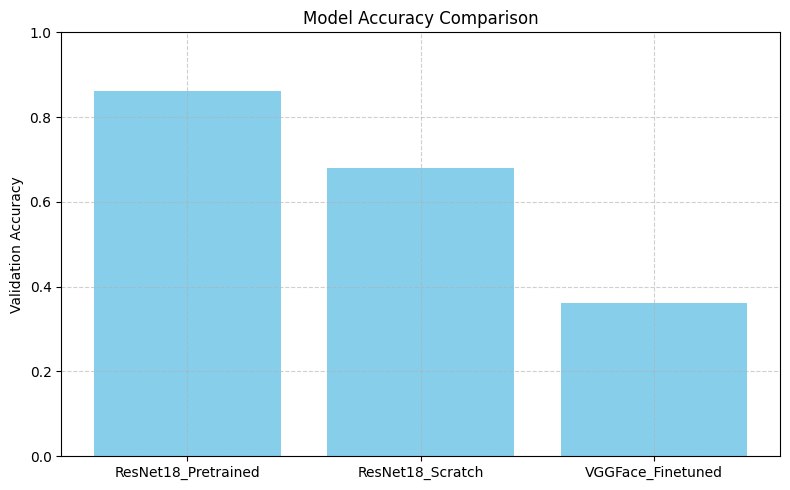

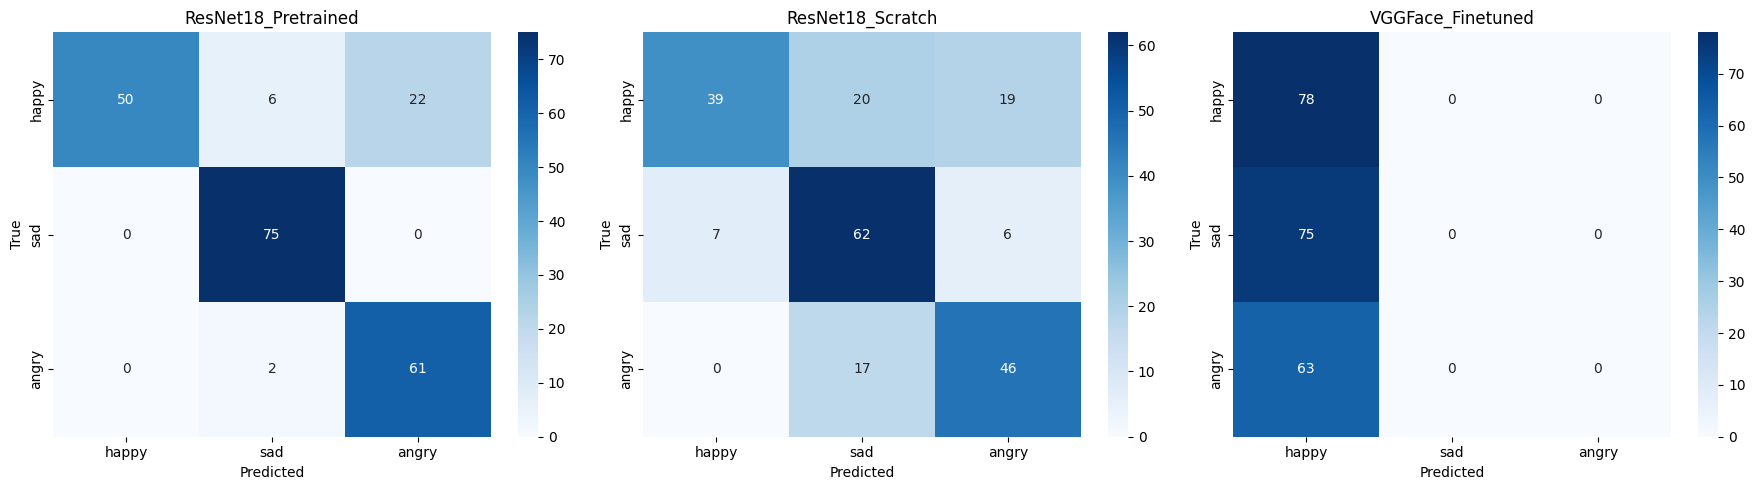

In [16]:
# ✅ 8. Visualizations
plt.figure(figsize=(8, 5))
plt.bar(model_results.keys(), model_results.values(), color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model_name, cm) in zip(axes, model_conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
                yticklabels=class_names, cmap='Blues', ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

In [17]:
# ✅ 9. Save CSV
all_test_images = []
for emotion in class_names:
    emotion_folder = os.path.join(DATA_ROOT, "Test", emotion)
    all_test_images.extend(sorted(glob.glob(os.path.join(emotion_folder, "*"))))

if len(all_test_images) == len(test_labels):
    annotation_df = pd.DataFrame({
        "image_name": [os.path.basename(path) for path in all_test_images],
        "true_emotion": [class_names[i] for i in test_labels],
        "predicted_emotion": [class_names[i] for i in best_y_pred]
    })
    annotation_df.to_csv("/content/drive/MyDrive/annotations.csv", index=False)
    print(" annotations.csv saved.")
    display(annotation_df.head())
else:
    print(" Image count mismatch: CSV not saved.")

 annotations.csv saved.


,image_name,true_emotion,predicted_emotion
0,aug_0_image_0006.jpg,happy,happy
1,aug_0_image_0007.jpg,happy,happy
2,aug_0_image_0008.jpg,happy,angry
3,aug_0_image_0009.jpg,happy,happy
4,aug_1_image_0000.jpg,happy,sad


In [ ]:
!rm -rf /content/emotion_dataset
print("🧹 Old dataset removed.")
